# Retrieval Augmented Generation (RAG)

Language models know lots about the world but not everything, especially if you're working on a project in a specific domain.

Retrieval Augmented Generation (RAG) is a method for passing some extra knowledge to your LLM which improves the quality of the outputs for many tasks

In [ ]:
!pip install -q chromadb
!pip install -U -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 5.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 617.9/617.9 kB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.6/278.6 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 4.0 MB/s eta 0:00:00


RAG systems consist of 2 key components:
- Retriever - fetches the most relevent documents for a query
- LLM - takes the retrieved documents and uses them to produce the final answer.


They're used together like this:


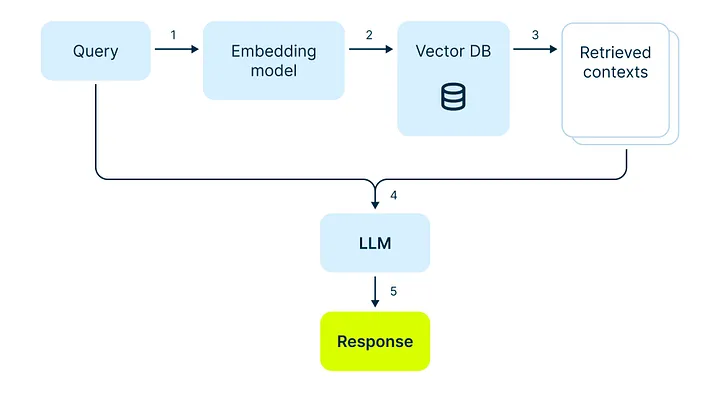

# A Super Simple example

Let's start simple. Here's a short collection of documents with events to do tonight:

In [ ]:
documents = [
    {
        "title":"Healing Breathwork | Accelerate emotional and physical healing",
        "time": "18:00",
        "url": "https://www.eventbrite.com/e/healing-breathwork-accelerate-emotional-and-physical-healing-york-tickets-1061227753779"
    },
    {
        "title": "Private Client Tax Conference",
        "time": "09:30",
        "url": "https://www.eventbrite.co.uk/e/private-client-tax-conference-tickets-1044755510857"
    },
    {
        "title": "Minskip - New and Award Winning Cheese Tasting! - 19:00",
        "time": "19:00",
        "url": "https://www.eventbrite.co.uk/e/minskip-new-and-award-winning-cheese-tasting-tickets-921412679127"
    },
    {
        "title": "Gong Sound Bath",
        "time": "19:30",
        "url": "https://www.eventbrite.co.uk/e/gong-sound-bath-tickets-1034688780997"
    },
    {
        "title": "Make your own Gingerbread House",
        "time": "09:00",
        "url": "https://www.eventbrite.co.uk/e/make-your-own-gingerbread-house-tickets-1083962764809"
    },
    {
        "title": "Group Guitar Classes",
        "time": "19:00",
        "url": "https://www.eventbrite.co.uk/e/group-guitar-classes-north-leeds-adults-tickets-881193693057"
    },
    {
        "title": "Shamanic Journey & Art Flow",
        "time": "19:00",
        "url": "https://www.eventbrite.co.uk/e/shamanic-journey-art-flow-tickets-1055684042389"
    },
    {
        "title": "Fun Puzzle Treasure Hunt! :)",
        "time": "10:00",
        "url": "https://www.eventbrite.co.uk/e/york-fun-puzzle-treasure-hunt-tickets-39215532714"
    },
    {
        "title": "Murder Mystery Experience",
        "time": "08:00",
        "url": "https://www.eventbrite.com/e/murder-mystery-experience-york-tickets-1079484369809"
    },
    {
        "title": "Singing Class",
        "time": "18:30",
        "url": "https://www.eventbrite.co.uk/e/singing-lab-group-classes-for-kids-north-leeds-tickets-861948460047"
    },
    {
        "title": "Weekly Crochet Group",
        "time": "13:00",
        "url": "https://www.eventbrite.co.uk/e/weekly-crochet-group-tickets-1022371479617"
    },
    {
        "title": "Leadership Secrets: 7 Secrets for Your Success",
        "time": "10:30",
        "url": "https://www.eventbrite.com/e/leeds-leadership-secrets-7-secrets-for-your-success-they-wont-teach-you-tickets-818644907957"
    },
    {
        "title": "Piano Group Classes for Kids",
        "time": "16:30",
        "url": "https://www.eventbrite.co.uk/e/piano-group-classes-for-kids-ls11-south-leeds-tickets-919309047107"
    }
]

We need to compute an embedding for each of these documents. This embedding will allow us to compute a similarity score with our query. We call the combination of `documents + embeddings` a vector database.

There are loads of different choices for vectorDB libraries. We'll use a very simple one: chromadb

In [ ]:
%env ALLOW_RESET=TRUE

env: ALLOW_RESET=TRUE


In [ ]:
import chromadb

client = chromadb.Client()
client.reset()
events_collection = client.create_collection(name="events",
       metadata={"hnsw:space": "cosine"}
)
events_collection.add(
    documents=[d["title"] for d in documents],
    ids=[d["url"] for d in documents],
    metadatas=[{"time": d["time"]} for d in documents]
)

We can now query our vectorDB:

In [ ]:
results = events_collection.query(
  query_texts=["relaxation"],
  n_results=2
)
for r in results["documents"][0]:
  print(r)

Healing Breathwork | Accelerate emotional and physical healing
Shamanic Journey & Art Flow


# Adding the LLM

Now we can retrieve relevent documents, let's pass them to the LLM. There are libraries such as [langchain](https://python.langchain.com/docs/introduction/) which can wrap all this up for you. For now we'll just write a function which does the same.

First let's load our LLM:

In [ ]:
from transformers import pipeline

model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
pipe = pipeline("text-generation", model_name, device_map="auto")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Now we can write a function which retrieves some documents and plans a day out based on a user's interests:

In [ ]:
def plan_a_day(description_of_user):
  # First we do the query
  results = events_collection.query(
    query_texts=[description_of_user],
    n_results=3
  )

  results_str = "\n".join([d[0] + " - " + d[1]["time"] for d in zip(results["documents"][0], results["metadatas"][0])])

  # Then pass the results to the LLM
  messages = [
      {"role": "system", "content": "You are a helpful trip planner"},
      {"role": "user", "content": f"Hi, I am {description_of_user} and want to plan a trip. Given the following potential options, plan me an itinerary with relevent activities: \n\n{results_str}"},
  ]

  output = pipe(messages)[0]["generated_text"][-1]
  return output["content"]

print(plan_a_day("a serious businessman"))

To plan a great day out for you, here are some options:

1. Leadership Secrets: 7 Secrets for Your Success - 10:30
This workshop is a great way to learn leadership skills and strategies that can help you succeed in your professional life. The workshop will cover topics such as time management, communication skills, teamwork, and goal setting. You can expect to leave the workshop with practical tips and strategies that you can apply in your daily work.

2. Murder Mystery Experience - 08:00
This murder mystery experience is a fun and interactive way to spend a day out. You will be part of a team of detectives trying to solve a murder mystery. The experience will involve a series of clues, puzzles, and riddles that will keep you on your toes. You will also have the opportunity to meet other guests and make new friends.

Both options are suitable for businessmen and women who want to learn new skills and have fun at the same time. You can choose one or both options based on your preference